# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

In [25]:
import numpy as np

from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

In [2]:
dataset = load_dataset('google-research-datasets/go_emotions', split='train')


Generating test split: 100%|██████████| 5427/5427 [00:00<00:00, 1261778.70 examples/s]


In [3]:
dataset

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 43410
})

Print some examples

In [4]:
for i in range(5):
    print(f"Text {i+1}: {dataset[i]['text']}")

Text 1: My favourite food is anything I didn't have to cook myself.
Text 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Text 3: WHY THE FUCK IS BAYLESS ISOING
Text 4: To make her feel threatened
Text 5: Dirty Southern Wankers


## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [5]:
# Загружаем предобученную модель для создания эмбеддингов
model = SentenceTransformer('all-MiniLM-L6-v2')

texts = dataset['text']
embeddings = model.encode(texts, show_progress_bar=True)
embeddings = np.array(embeddings)

print(f"Shape of embeddings: {embeddings.shape}")


Batches: 100%|██████████| 1357/1357 [00:52<00:00, 25.66it/s]


Shape of embeddings: (43410, 384)


## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at leas four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [7]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def cosine_distance(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.sqrt(np.sum(a ** 2))
    norm_b = np.sqrt(np.sum(b ** 2))
    
    if norm_a == 0 or norm_b == 0:
        return 1.0
    
    return 1.0 - (dot_product / (norm_a * norm_b))

def mahalanobis_distance(a, b, **kwargs):
    inv_cov = kwargs.get('inv_cov', None)
    if inv_cov is None:
        raise ValueError("Для расстояния Махаланобиса требуется обратная ковариационная матрица")
    
    diff = a - b
    return np.sqrt(np.dot(np.dot(diff, inv_cov), diff))

def correlation_distance(a, b):
    # Используем np.corrcoef для вычисления корреляции
    try:
        corr = np.corrcoef(a, b)[0, 1]
        if np.isnan(corr):
            return 1.0
        return 1.0 - corr
    except:
        return 1.0

Implement custom K-Means class

In [14]:
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, distance_metric='euclidean',  **kwargs):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.centroids = None
        self.labels_ = None
        self.kwargs = kwargs

    def fit(self, X):
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in tqdm(range(self.max_iter)):
            self.labels_ = np.array([self._assign_label(x) for x in X])

            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) if len(X[self.labels_ == i]) > 0 else self.centroids[i] for i in range(self.n_clusters)])

            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

    def _assign_label(self, x):
        distances = []
        
        for centroid in self.centroids:
            if self.distance_metric == 'euclidean':
                dist = euclidean_distance(x, centroid)
            elif self.distance_metric == 'cosine':
                dist = cosine_distance(x, centroid)
            elif self.distance_metric == 'mahalanobis':
                dist = mahalanobis_distance(x, centroid, **self.kwargs)
            elif self.distance_metric == 'correlation':
                dist = correlation_distance(x, centroid)
            else:
                raise ValueError(f"Неподдерживаемая метрика расстояния: {self.distance_metric}")
            
            distances.append(dist)
            
        return np.argmin(distances)


## 4. Fit the custom K-Means

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [15]:
n_clusters = 10

# Евклидово расстояние
kmeans_euclidean = CustomKMeans(n_clusters=n_clusters, distance_metric='euclidean')
kmeans_euclidean.fit(embeddings)
labels_euclidean = kmeans_euclidean.labels_

# Косинусное расстояние
kmeans_cosine = CustomKMeans(n_clusters=n_clusters, distance_metric='cosine')
kmeans_cosine.fit(embeddings)
labels_cosine = kmeans_cosine.labels_

# Корреляционное расстояние
kmeans_correlation = CustomKMeans(n_clusters=n_clusters, distance_metric='correlation')
kmeans_correlation.fit(embeddings)
labels_correlation = kmeans_correlation.labels_

# Расстояние Махаланобиса
cov_matrix = np.cov(embeddings, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
kmeans_mahalanobis = CustomKMeans(n_clusters=n_clusters, distance_metric='mahalanobis', inv_cov=inv_cov_matrix)
kmeans_mahalanobis.fit(embeddings)
labels_mahalanobis = kmeans_mahalanobis.labels_

print("Метки кластеров CustomKMeans с евклидовым расстоянием (первые 10 текстов):")
print(labels_euclidean[:10])
print("\nМетки кластеров CustomKMeans с косинусным расстоянием (первые 10 текстов):")
print(labels_cosine[:10])
print("\nМетки кластеров CustomKMeans с корреляционным расстоянием (первые 10 текстов):")
print(labels_correlation[:10])
print("\nМетки кластеров CustomKMeans с расстоянием Махаланобиса (первые 10 текстов):")
print(labels_mahalanobis[:10])



100%|██████████| 100/100 [55:19<00:00, 33.19s/it]

Метки кластеров CustomKMeans с евклидовым расстоянием (первые 10 текстов):
[5 9 8 3 5 6 5 4 7 3]

Метки кластеров CustomKMeans с косинусным расстоянием (первые 10 текстов):
[9 0 9 3 9 6 1 8 1 3]

Метки кластеров CustomKMeans с корреляционным расстоянием (первые 10 текстов):
[6 4 3 7 3 2 1 9 1 7]

Метки кластеров CustomKMeans с расстоянием Махаланобиса (первые 10 текстов):
[8 6 9 0 6 9 6 2 5 0]


In [19]:
labels = {"correlation":labels_correlation, "euclidean":labels_euclidean, "cosine":labels_cosine, "mahalanobis":labels_mahalanobis}

## 5. Visualize the results

Visualize the clusters by reducing the dimensionality of the embeddings using PCA and plotting the clusters in 2D space.  


In [37]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

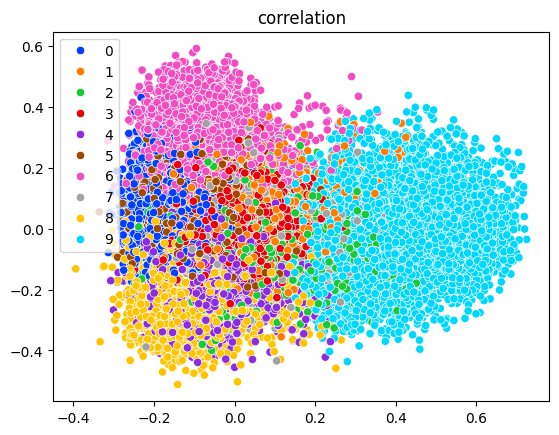

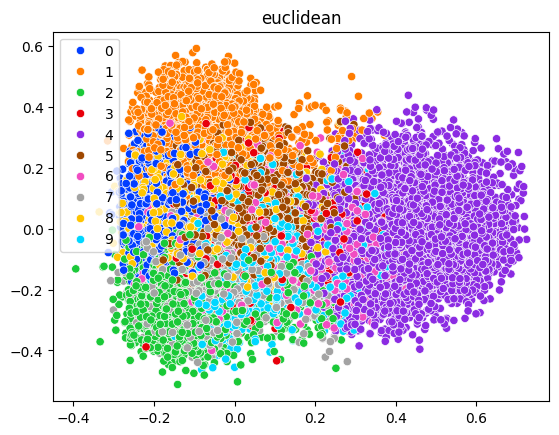

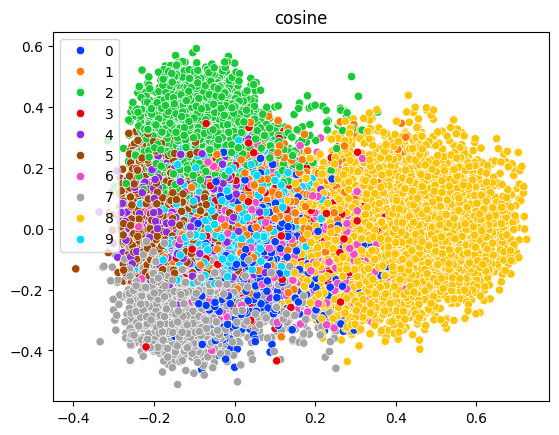

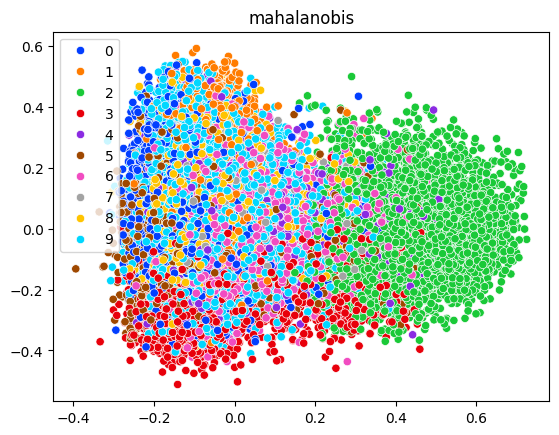

In [39]:
for method in labels:
    plt.title(method)
    sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=labels[method], palette='bright')
    plt.show()

Let's print examples of the text for each cluster

In [32]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [texts[i] for i in range(len(texts)) if labels['cosine'][i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
- Fucking coward.
- Pretty sure I’ve seen this. He swings away with the harness he is wearing. Still looks painful but I think he lives
- I read on a different post that he died shortly after of internal injuries.
- It's true though. He either gets no shirt and freezes to death or wears a stupid looking butchers cape. I hope he gets something better next season

Cluster 1:
- Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝
- Damn youtube and outrage drama is super lucrative for reddit
- Shit, I guess I accidentally bought a Pay-Per-View boxing match
- I miss them being alive
- It's crazy how far Photoshop has come. Underwater bridges?!! NEVER!!!

Cluster 2:
- Hello everyone. Im from Toronto as well. Can call and visit in personal if needed.
- Thank you friend
- Happy to be able to help.
- aw, 

## 6. Report

Make a conclusion and write a short report. What are the differnes between the methods used? What are their limitations? What is the applicability of each?

В крупные и отлчетливо выделяющиеся кластеры попадают тексты с
(расссматриваем cosine)
- вежливыми обращениями (кластер 2)
- наличием [NAME] (кластер 8)
- политической тематикой (кластер 7)

Различия методов кластеризации эмбеддингов:
- Mahalanobis – учитывает ковариацию, полезен для коррелированных данных, но требует хорошей оценки ковариационной матрицы.
- Cosine Similarity – измеряет угол между векторами, идеален для текстов, но не учитывает длину эмбеддингов.
- Euclidean Distance – простое физическое расстояние, плохо работает при разном масштабе признаков.
- Correlation Distance – анализирует тренды, полезен для временных рядов, но игнорирует абсолютные значения.

Применимость:
Cosine и Correlation – лучше для текстов.
Mahalanobis – если есть корреляция в данных.
Euclidean – когда важно абсолютное расстояние.